**Consulta a GPT**

> Se define un prompt en donde se envian todos los mensajes por usuario a GPT para que identifique caracteristicas que puedan indicar asiedad o depresion. Retorna un JSON con las caracteristicas detectadas para cada usuario



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import json
import os
from google.colab import drive
from openai import OpenAI
import time


#apikey kath
api_key="apikey"


client = OpenAI(api_key=api_key)


# 📌 Función para cargar el CSV
def cargar_mensajes_csv(ruta_archivo):
    df = pd.read_csv(ruta_archivo)

    # 📌 Verificar que las columnas necesarias existen
    columnas_requeridas = {'subject_id', 'message'}
    if not columnas_requeridas.issubset(df.columns):
        raise ValueError(f"El archivo CSV debe contener las columnas {columnas_requeridas}")

    return df

# 📌 Función para identificar características en los mensajes
def identificar_caracteristicas(mensajes_usuario):
    try:
        mensajes_concatenados = "\n".join(mensajes_usuario)

        prompt = (
          "Analiza los siguientes mensajes de un usuario e identifica las características más relevantes en su forma de expresarse. "
          "Los usuarios pueden mostrar signos de depresión, ansiedad o no presentar características significativas.\n\n"

          "📌 **Instrucciones para la respuesta:**\n"
          "- Si el usuario no presenta patrones relacionados con depresión o ansiedad, responde exactamente con: \"Sin características detectadas\".\n"
          "- Si detectas características, responde las caracterisricas encontradas:\n\n"

          "📌 **Reglas para la detección de características:**\n"
          "- No asumas diagnósticos, solo identifica patrones en la forma de expresarse.\n"
          "- Enumera solo las características principales que sugieren depresión y/o ansiedad.\n"
          "- No incluyas ninguna introducción ni explicación adicional, solo lista las características.\n"
          "- Usa un lenguaje claro y estandarizado para que las características puedan agruparse fácilmente.\n"
          "- No uses sinónimos o variaciones innecesarias. Por ejemplo, usa 'Tristeza' en lugar de 'Melancolía' o 'Sentirse triste'.\n"
          "- Si el usuario no presenta signos claros, responde con 'Sin características detectadas'.\n\n"

          "📌 **Ejemplo de respuesta esperada:**\n"
          "\"['Tristeza', 'Falta de motivación', 'Aislamiento social']\"\n"
          "\"['Ansiedad', 'Pensamientos acelerados', 'Irritabilidad']\"\n"
          "\"Sin características detectadas\"\n"
          "\"['Tristeza', 'Ansiedad', 'Insomnio']\"\n\n"

          "Ahora analiza los siguientes mensajes del usuario y devuelve la respuesta en el formato especificado:\n"
        )

        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Eres un asistente que analiza mensajes para identificar signos de depresión y ansiedad, o bien, determinar que no hay señales relevantes."},
                {"role": "user", "content": prompt + "\n" + mensajes_concatenados}
            ],
            max_tokens=300,
            temperature=0.0,
            top_p=1.0
        )

        # Procesamiento de la respuesta
        contenido = response.choices[0].message.content.strip()
        caracteristicas_usuario = contenido.strip().split("\n")
        caracteristicas_usuario = [c.strip().lower() for c in caracteristicas_usuario if c and not c.lower().startswith("basándome")]

        if len(caracteristicas_usuario) == 1 and caracteristicas_usuario[0] in ["sin características detectadas", "sin caracteristicas detectadas"]:
            return ["sin caracteristicas detectadas"]
        else:
            return caracteristicas_usuario

    except Exception as e:
        print(f"⚠️ Error al procesar la API de OpenAI: {e}")
        return ["sin caracteristicas detectadas"]



# 📌 Cargar los mensajes desde el archivo CSV

ruta_archivo = '/content/drive/MyDrive/MachineLearning/TEST/Procesamiento con GPT/TEST_Mensajes_concatenados.csv'

df = cargar_mensajes_csv(ruta_archivo)

# 📌 Optimización: Obtener mensajes agrupados por usuario
mensajes_por_usuario = df.groupby('subject_id')['message'].agg(list).to_dict()

# 📌 Diccionario para almacenar características por usuario
caracteristicas_por_usuario = {}

# 📌 Analizar características de cada usuario
for usuario, mensajes in mensajes_por_usuario.items():
    caracteristicas = identificar_caracteristicas(mensajes)
    caracteristicas_por_usuario[usuario] = caracteristicas
    time.sleep(1.2)

# 📌 Guardar JSON en el nuevo formato (agrupado por usuario)
ruta_guardado = '/content/drive/MyDrive/MachineLearning/TEST/Procesamiento con GPT/GPT_caracteristicas_por_usuarioSI.json'

with open(ruta_guardado, 'w') as archivo_json:
    json.dump(caracteristicas_por_usuario, archivo_json, indent=4,ensure_ascii=False)

print(f"✅ Resultado guardado en {ruta_guardado}")


✅ Resultado guardado en /content/drive/MyDrive/MachineLearning/TEST/Procesamiento con GPT/GPT_caracteristicas_por_usuarioSI.json


**Limpieza de datos**
post-procesar tu archivo JSON

In [ ]:
import json
import re
from google.colab import files

# 1️⃣ 📂 Subir el archivo JSON desde la computadora
uploaded = files.upload()
input_filename = list(uploaded.keys())[0]

# 2️⃣ 🧹 Función para limpiar y normalizar cada línea de características
def clean_line(line):
    line = line.strip().lstrip("-").strip().rstrip(".").strip()
    if not line or line == "-":
        return None

    # Lista de encabezados no deseados
    headers = [
        "expresión del pensamiento:",
        "uso del lenguaje:",
        "conducta comunicativa:",
        "expresión de sentimientos:"
    ]

    lower_line = line.lower()
    for header in headers:
        if lower_line.startswith(header):
            line = line[len(header):].strip()
            break

    return line if line else None

# 3️⃣ 🔄 Función para unificar sinónimos y normalizar términos
def unify_synonyms(line):
    synonyms = {
        "pensamientos negativos recurrentes": "pensamiento negativo",
        "pensamiento negativo recurrente": "pensamiento negativo",
        "patrones de pensamiento negativo": "pensamiento negativo",
        "expresiones de autodesprecio": "autodesprecio",
        "desesperanza": "falta de esperanza",
        "aislamiento social": "aislamiento",
        "insomnio": "dificultad para dormir",
        "uso de emojis para expresar emociones": "uso de emojis",
        "uso frecuente de emojis": "uso de emojis",
        "uso de emojis frecuente": "uso de emojis",
        "menciones a ansiedad": "ansiedad",
        "expresión de ansiedad": "ansiedad"
    }

    for key, canonical in synonyms.items():
        pattern = r"\b" + re.escape(key) + r"\b"
        line = re.sub(pattern, canonical, line, flags=re.IGNORECASE)

    return line

# 4️⃣ 📥 Cargar y limpiar el JSON original
def load_and_clean_json(filename):
    with open(filename, "r", encoding="utf-8") as f:
        data = json.load(f)

    cleaned_data = {}
    for subject, lines in data.items():
        cleaned_lines = []
        for line in lines:
            cl = clean_line(line)
            if cl:
                cl = unify_synonyms(cl.lower())
                if cl:
                    cleaned_lines.append(cl)
        if cleaned_lines:
            cleaned_data[subject] = list(dict.fromkeys(cleaned_lines))  # Eliminar duplicados manteniendo el orden

    return cleaned_data

# 5️⃣ 💾 Guardar JSON limpio en un archivo
def save_json(data, filename):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)
    print(f"✅ JSON limpio guardado en '{filename}'")

# 🚀 Ejecutar el proceso de limpieza
cleaned_data = load_and_clean_json(input_filename)
save_json(cleaned_data, "cleaned_characteristics.json")


Saving cleaned_characteristics_solo_caracteristicas.json to cleaned_characteristics_solo_caracteristicas.json
✅ JSON limpio guardado en 'cleaned_characteristics.json'


**Top de caracteristicas**

✅ JSON con el Top de Características guardado en 'top_characteristics.json'


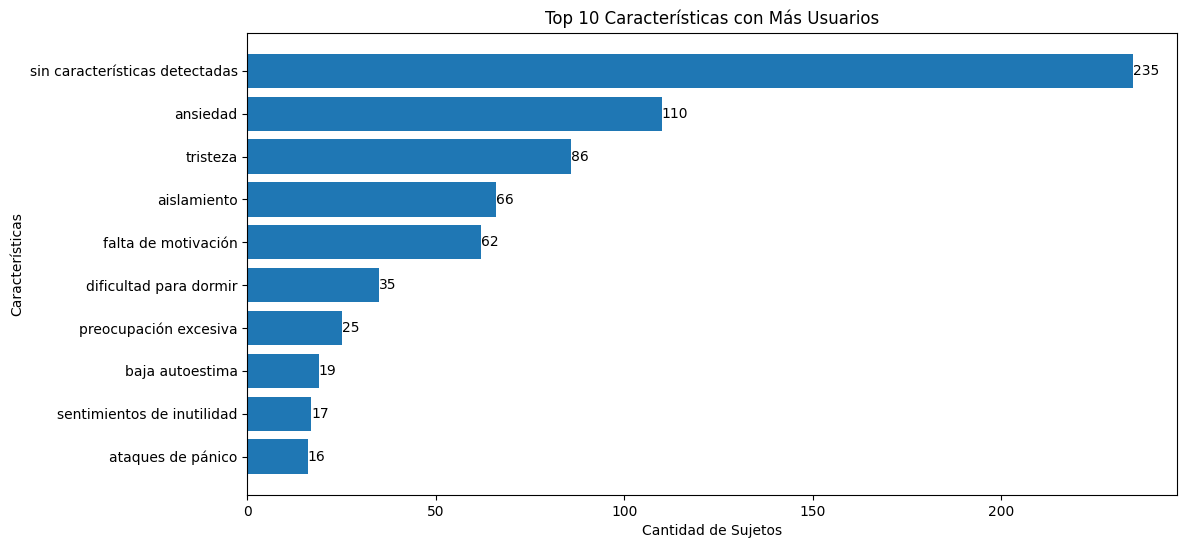

In [ ]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# 1️⃣ 📂 Cargar el JSON limpio
input_filename = "cleaned_characteristics.json"

with open(input_filename, "r", encoding="utf-8") as f:
    cleaned_data = json.load(f)

# 2️⃣ 📊 Contar cuántos sujetos tienen cada característica
characteristic_counts = Counter()

for subject, characteristics in cleaned_data.items():
    for characteristic in characteristics:
        characteristic_counts[characteristic] += 1

# 3️⃣ 🔢 Obtener el total de sujetos estudiados
total_subjects = len(cleaned_data)

# 4️⃣ 🎯 Crear un diccionario con porcentaje de usuarios por característica
characteristic_percentage = {
    char: {
        "Subjects": count,
        "Percentage": f"{(count / total_subjects) * 100:.2f}%"
    }
    for char, count in characteristic_counts.items()
}

# 5️⃣ 💾 Guardar el JSON con conteos y porcentajes
output_filename = "top_characteristics.json"
with open(output_filename, "w", encoding="utf-8") as f:
    json.dump(characteristic_percentage, f, indent=4, ensure_ascii=False)

print(f"✅ JSON con el Top de Características guardado en '{output_filename}'")

# 6️⃣ 📊 Obtener el Top 10 de características más frecuentes
top_10 = characteristic_counts.most_common(10)
chars, counts = zip(*top_10)

# 7️⃣ 📈 Generar gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.barh(chars, counts)
plt.xlabel("Cantidad de Sujetos")
plt.ylabel("Características")
plt.title("Top 10 Características con Más Usuarios")

# 8️⃣ 📌 Añadir etiquetas a las barras
for bar, count in zip(bars, counts):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(count), va="center")

plt.gca().invert_yaxis()
plt.show()


**Caracteristicas relevantes**

In [ ]:
import json
import csv

# 📂 1️⃣ Cargar el JSON limpio
input_filename = "cleaned_characteristics.json"

with open(input_filename, "r", encoding="utf-8") as f:
    cleaned_data = json.load(f)

# 🎯 2️⃣ Definir los síntomas exactos para ansiedad y depresión
anxiety_symptoms = {
    "ansiedad",
    "dificultad para dormir",
    "ataques de ansiedad",
    "síntomas físicos de ansiedad",
    "pensamientos repetitivos"
}

depression_symptoms = {
    "pensamiento negativo",
    "depresión",
    "expresión de tristeza y desánimo",
    "pensamientos suicidas",
    "aislamiento",
    "desesperanza"
}

# 🔍 3️⃣ Clasificar sujetos con Ansiedad (1) y/o Depresión (1)
subjects_classification = {}

for subject, characteristics in cleaned_data.items():
    has_anxiety = any(char in anxiety_symptoms for char in characteristics)
    has_depression = any(char in depression_symptoms for char in characteristics)

    subjects_classification[subject] = {
        "ansiedad_binaria": int(has_anxiety),
        "depresion_binaria": int(has_depression)
    }

# 💾 4️⃣ Guardar JSON con clasificación binaria
output_json_filename = "subjects_anxiety_depression.json"
with open(output_json_filename, "w", encoding="utf-8") as f:
    json.dump(subjects_classification, f, indent=4, ensure_ascii=False)

print(f"✅ JSON con clasificación binaria guardado en '{output_json_filename}'")

# 📄 5️⃣ Guardar CSV con clasificación binaria
output_csv_filename = "subjects_anxiety_depression.csv"
with open(output_csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    fieldnames = ["ID Sujeto", "Ansiedad", "Depresión"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for subject, values in subjects_classification.items():
        writer.writerow({"ID Sujeto": subject, "Ansiedad": values["ansiedad_binaria"], "Depresión": values["depresion_binaria"]})

print(f"✅ CSV con clasificación binaria guardado en '{output_csv_filename}'")


✅ JSON con clasificación binaria guardado en 'subjects_anxiety_depression.json'
✅ CSV con clasificación binaria guardado en 'subjects_anxiety_depression.csv'
